In [14]:
import pickle
from datetime import datetime as dtdt

import attrs
import numpy as np

from hetero.algo import BetaOptimizer, MCPImpl
from hetero.config import DTYPE, AlgoConfig, DataGenConfig, GroupingConfig
from hetero.datagen import extract_first_n_order, generate_data_from_config
from hetero.policies import AlternativePolicy
from hetero.tasks import (
    beta_estimate_from,
    beta_estimate_from_e2e_learning,
    beta_estimate_from_nongrouped,
    compute_UV_truths,
    compute_V_estimate,
)
from hetero.utils import action_feature_prod, generate_decay_matrix, lookup_inner

In [3]:
MAX_LEGENDRE_ORDER = 4
TRUE_LEGENDRE_ORDER = 2
assert TRUE_LEGENDRE_ORDER < MAX_LEGENDRE_ORDER

SEED = 8888  # 1818

coeff_rand = np.random.RandomState(SEED)  # (7531)

group_reward_coeff = np.array(
    [
        [-2, 2, 2, -2, 0, 0, 0, 0],
        [2, -2, -2, 2, 0, 0, 0, 0],
    ],
    dtype=DTYPE,
)

action_reward_coeff = [-1, 1]

FEATURE_TYPE = "LEGENDRE"
TRANS = "NORMCDF"
NOISE = "STUDENT"

In [4]:
FEATURE_TYPE = "LEGENDRE"
TRANS = "NORMCDF"
NOISE = "STUDENT"

data_config_init = dict(
    num_trajectories=100,
    num_time_steps=40,
    group_reward_coeff_override=group_reward_coeff,
    action_reward_coeff=action_reward_coeff,
    num_burnin_steps=100,
    basis_expansion_method=FEATURE_TYPE,
    basis_expansion_factor=MAX_LEGENDRE_ORDER,
    transformation_method=TRANS,
    add_intercept_column=True,
    noise_type=NOISE,
    noise_student_degree=4,
)

time_tag = dtdt.now().strftime("%Y%m%d_%H-%M-%S")
tag = f'N={data_config_init["num_trajectories"]}_T={data_config_init["num_time_steps"]}_{time_tag}'
RESULT_FILE = f"hetero/data/{FEATURE_TYPE}_{TRANS}_{NOISE}_result_20230528_{tag}.pkl"
print("result file name =", RESULT_FILE)
SAVE_RESULT = False
if not SAVE_RESULT:
    print("Result will NOT be saved, only use this for experimental runs!!!")

result file name = hetero/data/LEGENDRE_NORMCDF_STUDENT_result_20230528_N=100_T=40_20230603_22-06-59.pkl
Result will NOT be saved, only use this for experimental runs!!!


=====================================================================================================

In [5]:
algo_config = AlgoConfig(
    max_num_iters=10,
    gam=2.7,
    lam=2.0,
    rho=2.0,
    # should_remove_outlier=True,
    # outlier_lower_perc=2,
    # outlier_upper_perc=98,
    nu_coeff=0,
    delta_coeff=0,
    use_group_wise_regression_init=True,
)

pi_eval = AlternativePolicy(2)

grouping_config = GroupingConfig()

In [6]:
FULL_DATA_CONFIG = DataGenConfig(seed=SEED, **data_config_init)
FULL_DATA = generate_data_from_config(FULL_DATA_CONFIG)

In [8]:
print(FULL_DATA.current_features[:3, :])
print(FULL_DATA.next_features[:3, :])

[[0.23030634 0.37052292 0.62422955 0.36836544 0.54083973 0.6574366
  0.35573977 0.5070384  1.        ]
 [0.86754966 0.45787346 0.91378623 0.31447265 0.9634393  0.5618766
  0.9933023  0.6306509  1.        ]
 [0.5628606  0.2707383  0.32188046 0.5236095  0.41004246 0.6356274
  0.6117409  0.33908266 1.        ]]
[[0.91535705 0.38602734 0.9901991  0.35415715 0.9999953  0.6457072
  1.         0.5362987  1.        ]
 [0.1894819  0.20580925 0.745723   0.6953881  0.35091567 0.43953726
  0.53730273 0.43455762 1.        ]
 [0.9999619  0.57452893 1.         0.3274263  1.         0.3953949
  1.         0.5979457  1.        ]]


In [39]:
def compute_combined_residuals(data, pi_eval, discount, betas):
    Z = action_feature_prod(data.actions, data.current_features)
    pi_eval_actions = pi_eval.action(data.next_features)
    U = action_feature_prod(pi_eval_actions, data.next_features)

    v = Z - discount * U
    left = np.einsum("id,ie->ide", Z, v)
    right = Z * data.rewards.reshape([-1, 1])
    partitioner = data.partitioner

    beta_indices = np.array(
        [partitioner.label_to_index(x) for x in data.labels], dtype=np.int32
    )
    beta_expanded = lookup_inner(betas, beta_indices)
    sigma = left.sum(axis=0) / data.NT()
    right = right.sum(axis=0)
    residuals = data.rewards - (v * beta_expanded).sum(axis=1)
    omega = np.einsum("id,ie,i->de", Z, Z, residuals**2) / data.NT()
    return dict(
        betas=betas,
        sigma=sigma,
        residuals=residuals,
        omega=omega,
        num_samples=data.NT(),
    )

In [40]:
residuals_list = []
print("FULL_FEATURE_SHAPE=", FULL_DATA.current_features.shape)
for order in range(1, MAX_LEGENDRE_ORDER + 1):
    data = extract_first_n_order(FULL_DATA, order, FULL_DATA_CONFIG)
    print("FEATURE_SHAPE=", data.current_features.shape)
    impl = MCPImpl(data.N(), algo_config)
    beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
    betas = beta_opt.compute()
    residuals = compute_combined_residuals(data, pi_eval, algo_config.discount, betas)
    residuals_list.append(residuals)

FULL_FEATURE_SHAPE= (8000, 9)
FEATURE_SHAPE= (8000, 3)
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11891, num_below=8009
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15124, num_below=4776
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11905, num_below=7995
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15149, num_below=4751
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11902, num_below=7998
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15144, num_below=4756
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11898, num_below=8002
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15153, num_below=4747
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=11910, num_below=7990
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=15139, num_below=4761
FEATURE_SHAPE= (8000, 5)
beta_solver, min eigen of left matrix = 1.0
MCPImpl: num_above=12712, 

In [41]:
x = [1, 2, 3, 4]
y = [np.sqrt((x["residuals"] ** 2).mean()) for x in residuals_list]
print(y)

[0.7984360395717708, 0.6478314309268901, 1.4320189920821786, 3.0909050260042616]


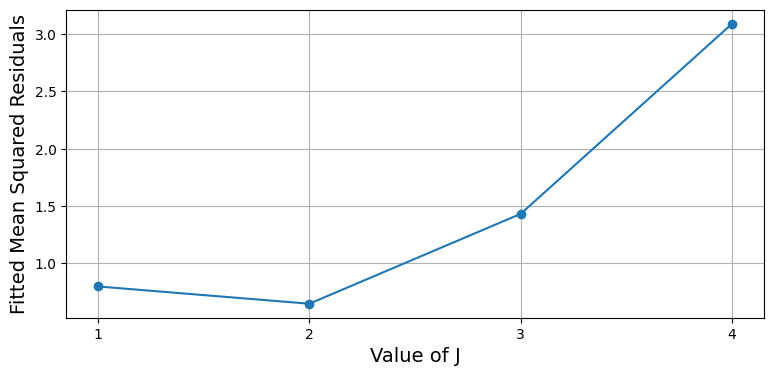

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.set_cmap("tab20")
plt.plot(x, y, marker="o")

# plt.title('Fitted Mean Squared Residuals V.S. J', fontsize=14)
plt.xticks(x)
plt.xlabel("Value of J", fontsize=14)
plt.ylabel("Fitted Mean Squared Residuals", fontsize=14)
plt.grid(True)

# plt.savefig(f"results/differ_J.pdf", bbox_inches="tight")

In [43]:
# Compute u_truth

NUM_REPEATS = 100
u_samples = {1: [], 2: [], 3: [], 4: []}
for i in range(NUM_REPEATS):
    full_config = DataGenConfig(seed=SEED * (i + 3), **data_config_init)
    full_data = generate_data_from_config(full_config)
    for order in range(1, 4 + 1):
        data = extract_first_n_order(full_data, order, full_config)
        pi_eval_actions = pi_eval.action(data.next_features)
        u_samples[order].append(
            action_feature_prod(pi_eval_actions, data.next_features).mean(axis=0)
        )
        print(f"Completed {i}'th repetition for order {order}")

Completed 0'th repetition for order 1
Completed 0'th repetition for order 2
Completed 0'th repetition for order 3
Completed 0'th repetition for order 4
Completed 1'th repetition for order 1
Completed 1'th repetition for order 2
Completed 1'th repetition for order 3
Completed 1'th repetition for order 4
Completed 2'th repetition for order 1
Completed 2'th repetition for order 2
Completed 2'th repetition for order 3
Completed 2'th repetition for order 4
Completed 3'th repetition for order 1
Completed 3'th repetition for order 2
Completed 3'th repetition for order 3
Completed 3'th repetition for order 4
Completed 4'th repetition for order 1
Completed 4'th repetition for order 2
Completed 4'th repetition for order 3
Completed 4'th repetition for order 4
Completed 5'th repetition for order 1
Completed 5'th repetition for order 2
Completed 5'th repetition for order 3
Completed 5'th repetition for order 4
Completed 6'th repetition for order 1
Completed 6'th repetition for order 2
Completed 6'

In [44]:
u_truth = {}
for order, us in u_samples.items():
    u_truth[order] = sum(us) / len(us)

print(u_truth)

{1: array([0.24996528, 0.24988924, 0.5       , 0.25014874, 0.25013527,
       0.5       ], dtype=float32), 2: array([0.24996528, 0.24988924, 0.31048936, 0.31046885, 0.5       ,
       0.25014874, 0.25013527, 0.30984485, 0.30994213, 0.5       ],
      dtype=float32), 3: array([0.24965   , 0.24981694, 0.30990955, 0.30994958, 0.24986605,
       0.24950218, 0.49929267, 0.25046396, 0.2502075 , 0.3104245 ,
       0.31046155, 0.25045308, 0.25033832, 0.50070727], dtype=float32), 4: array([0.24965   , 0.24981694, 0.30990955, 0.30994958, 0.24986605,
       0.24950218, 0.3248919 , 0.324939  , 0.49929267, 0.25046396,
       0.2502075 , 0.3104245 , 0.31046155, 0.25045308, 0.25033832,
       0.3257152 , 0.32544285, 0.50070727], dtype=float32)}


In [47]:
for (order, u), residuals in zip(u_truth.items(), residuals_list):
    sigma = (
        np.sqrt(
            u.reshape([1, -1])
            @ np.linalg.inv(residuals["sigma"])
            @ residuals["omega"]
            @ np.linalg.inv(residuals["sigma"]).T
            @ u.reshape([-1, 1])
        )[0, 0]
        / np.sqrt(residuals["num_samples"])    
    )
    print(order, sigma)

1 0.022312958034004727
2 0.017965336241819896
3 0.03971506875035885
4 0.08493631791635486
